# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#这段代码是机器学习实验中确保结果可重现的标准做法！
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [3]:
#如果GPU可用优先用GPU
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#绘制DNN的学习曲线（训练损失和验证损失）
def plot_learning_curve(loss_record, title=''):
    ''' 
    :param loss_record: 字典，包含'train'和'dev'键，分别对应训练和验证损失列表
    :param title: 字符串，图表标题
    :return: 无返回值，直接显示图表
    '''
    total_steps = len(loss_record['train'])  # 获取训练总步数
    x_1 = range(total_steps)  # 训练损失的x轴坐标（每个训练步）
    #sequence[start:stop:step][开始：结束：步长]
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]  # 验证损失的x轴坐标（按验证点数量等间隔采样）
    
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')  # 绘制训练损失曲线（红色）
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')     # 绘制验证损失曲线（青色）
    plt.ylim(0.0, 5.)  # 设置y轴显示范围为0到5
    plt.xlabel('Training steps')  # x轴标签：训练步数
    plt.ylabel('MSE loss')        # y轴标签：均方误差损失
    plt.title('Learning curve of {}'.format(title))  # 图表标题
    plt.legend()  # 显示图例
    plt.show()    # 显示图表



In [5]:
# 绘制DNN的预测结果（真实值 vs 预测值散点图）
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' 
    绘制模型预测结果与真实值的散点图，用于评估模型性能
    
    :param dv_set: 验证数据集 (DataLoader对象)
    :param model: 训练好的DNN模型需要模型的原因是如果没有预测值和真实值要重新计算，计算需要model中的参数
    :param device: 计算设备 ('cuda' 或 'cpu')
    :param lim: 坐标轴显示范围限制，默认为35.0
    :param preds: 可选的预计算预测值数组，如果为None则重新计算
    :param targets: 可选的预计算真实值数组，如果为None则重新计算
    '''
    # 如果没有提供预测值和目标值，则计算它们
    if preds is None or targets is None:
        model.eval()  # 设置模型为评估模式（关闭dropout、batchnorm等训练特定层）
        preds, targets = [], []  # 初始化预测值和真实值列表
        
        for x, y in dv_set:  # 遍历验证数据集中的每个batch（验证集也是分batch的）
            x, y = x.to(device), y.to(device)  # 将数据移动到指定设备（GPU或CPU）
            
            with torch.no_grad():  # 禁用梯度计算，节省内存和计算资源
                pred = model(x)  # 使用模型进行预测
                preds.append(pred.detach().cpu())      # 收集预测值（从计算图分离并移到CPU）
                targets.append(y.detach().cpu())       # 收集真实值（从计算图分离并移到CPU）
        
        # 合并所有batch的预测值和真实值
        preds = torch.cat(preds, dim=0).numpy()       # 在dim=0维度拼接，并转为numpy数组
        targets = torch.cat(targets, dim=0).numpy()   # 在dim=0维度拼接，并转为numpy数组

    # 创建图形
    figure(figsize=(5, 5))  # 设置正方形图像（5x5英寸）
    
    # 绘制散点图：真实值 vs 预测值
    plt.scatter(targets, preds, 
                c='r',        # 点颜色：红色
                alpha=0.5)    # 透明度：0.5（半透明，便于观察点密度）
    
    # 绘制对角线（理想预测线：y=x，表示完美预测）
    plt.plot([-0.2, lim],     # x坐标范围：从-0.2到lim
             [-0.2, lim],     # y坐标范围：从-0.2到lim（对角线）
             c='b',           # 线条颜色：蓝色
             label='Perfect prediction')  # 理想预测线
    
    # 设置坐标轴范围
    plt.xlim(-0.2, lim)  # 设置x轴显示范围：-0.2 到 lim
    plt.ylim(-0.2, lim)  # 设置y轴显示范围：-0.2 到 lim
    
    # 添加坐标轴标签
    plt.xlabel('ground truth value')  # x轴标签：真实值
    plt.ylabel('predicted value')     # y轴标签：预测值
    
    # 添加图表标题
    plt.title('Ground Truth v.s. Prediction')  # 图表标题：真实值 vs 预测值
    
    # 添加网格线（可选，便于读取数值）
    plt.grid(True, alpha=0.3)  # 显示网格，透明度0.3
    
    # 添加图例
    plt.legend()
    
    plt.show()  # 显示图表

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [6]:
class COVID19Dataset(Dataset):
    ''' COVID-19数据集加载和预处理类 '''
    def __init__(self,
                 path,               # 数据集文件路径
                 mode='train',       # 模式：'train'训练集, 'dev'验证集, 'test'测试集
                 target_only=False): # 是否只使用目标相关特征（True时只使用州特征和阳性测试特征）
        self.mode = mode

        # 从CSV文件读取数据到numpy数组
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))                    # 读取CSV文件所有行
            data = np.array(data[1:])[:, 1:].astype(float) # 转换为numpy数组，跳过标题行和第一列ID

        # 特征选择：决定使用哪些特征列
        if not target_only:
            # 使用所有93个特征
            feats = list(range(93))
        else:
            # TODO: 只使用40个州特征和2个阳性测试特征（索引57和75）
            state_feats = list(range(40))        # 前40列：州特征（one-hot编码）
            tested_positive_feats = [57, 75]     # 第57和75列：阳性测试相关特征
            feats = state_feats + tested_positive_feats  # 合并特征索引

        if mode == 'test':
            # 测试数据处理：893个样本 x 93个特征
            # 特征组成：40个州 + 第1天18个特征 + 第2天18个特征 + 第3天17个特征
            data = data[:, feats]                # 选择指定的特征列
            self.data = torch.FloatTensor(data)  # 转换为PyTorch浮点张量
        else:
            # 训练/验证数据处理：2700个样本 x 94个特征
            # 特征组成：40个州 + 第1天18个特征 + 第2天18个特征 + 第3天18个特征 + 目标值
            target = data[:, -1]                 # 最后一列是目标值（要预测的值）
            data = data[:, feats]                # 选择指定的特征列

            # 划分训练集和验证集（9:1比例）
            if mode == 'train':
                # 训练集：取不是10的倍数的索引（90%的数据）
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                # 验证集：取是10的倍数的索引（10%的数据）
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # 转换为PyTorch张量
            self.data = torch.FloatTensor(data[indices])    # 特征数据
            self.target = torch.FloatTensor(target[indices]) # 目标值

        # 特征标准化：对数值特征进行标准化处理
        # 注意：只对索引40及以后的特征标准化（州特征是one-hot编码，不需要标准化）
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]  # 特征维度（列数）

        # 打印数据集信息
        print('已完成读取COVID19数据集的{}集（找到{}个样本，每个样本维度={}）'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # 获取单个样本
        if self.mode in ['train', 'dev']:
            # 训练/验证模式：返回（特征，目标值）元组
            return self.data[index], self.target[index]
        else:
            # 测试模式：只返回特征数据（没有目标值）
            return self.data[index]

    def __len__(self):
        # 返回数据集大小（样本数量）
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [7]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' 
    生成数据集并创建数据加载器
    
    :param path: 数据文件路径
    :param mode: 模式 ('train', 'dev', 'test')
    :param batch_size: 批处理大小
    :param n_jobs: 数据加载的工作进程数，默认为0（主进程加载）
    :param target_only: 是否只使用目标相关特征，默认为False
    :return: 配置好的DataLoader对象
    '''
    # 创建COVID19Dataset数据集实例
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # 构造数据集对象
    
    # 创建DataLoader数据加载器
    dataloader = DataLoader(
        dataset,                    # 数据集对象
        batch_size,                 # 批处理大小
        shuffle=(mode == 'train'),  # 是否打乱数据：仅在训练模式下打乱
        drop_last=False,            # 是否丢弃最后一个不完整的batch：False表示保留
        num_workers=n_jobs,         # 数据加载的工作进程数（0表示在主进程加载）
        pin_memory=True             # 是否将数据锁页到内存（加速GPU数据传输）
    )                            
    
    return dataloader  # 返回数据加载器

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [8]:
class NeuralNet(nn.Module):
    ''' 一个简单的全连接深度神经网络 '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # 定义神经网络结构
        # TODO: 如何修改此模型以获得更好的性能？
        # 可以考虑：增加网络深度/宽度、添加dropout、使用不同的激活函数、批归一化等
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),  # 第一层：输入层 → 64个神经元
            nn.ReLU(),                 # ReLU激活函数
            nn.Linear(64, 32),         # 第二层：64个神经元 → 32个神经元  
            nn.ReLU(),                 # ReLU激活函数
            nn.Linear(32, 1)           # 输出层：32个神经元 → 1个输出（回归任务）
        )

        # 均方误差损失函数，reduction='mean'表示计算批处理的平均损失
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' 给定大小为 (batch_size x input_dim) 的输入，计算网络输出 '''
        # squeeze(1) 用于移除维度1（如果存在），确保输出为 (batch_size,)
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' 计算损失 '''
        # TODO: 可以在这里实现L1/L2正则化
        # 例如：添加L2正则化 -> l2_lambda * sum(p**2 for p in self.parameters())
        return self.criterion(pred, target)

In [9]:
class ImprovedNeuralNet(nn.Module):
    ''' 改进的全连接深度神经网络 '''
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3, l2_lambda=0.001):
        super(ImprovedNeuralNet, self).__init__()
        
        self.l2_lambda = l2_lambda  # L2正则化系数
        self.dropout_rate = dropout_rate
        
        # 构建动态的网络层
        layers = []
        prev_dim = input_dim
        
        # 添加隐藏层
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))  # 批归一化
            layers.append(nn.LeakyReLU(0.1))          # LeakyReLU激活函数
            layers.append(nn.Dropout(dropout_rate))    # Dropout防止过拟合
            prev_dim = hidden_dim
        
        # 输出层
        layers.append(nn.Linear(prev_dim, 1))
        
        self.net = nn.Sequential(*layers)
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' 前向传播 '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' 计算损失（包含L2正则化） '''
        mse_loss = self.criterion(pred, target)
        
        # 添加L2正则化
        l2_reg = torch.tensor(0., device=pred.device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)  # L2范数
        
        total_loss = mse_loss + self.l2_lambda * l2_reg
        return total_loss

 
# 使用示例
if __name__ == "__main__":
    # 创建改进的模型
    model = ImprovedNeuralNet(
        input_dim=100,           # 输入维度
        hidden_dims=[512, 256, 128, 64],  # 更深的网络结构
        dropout_rate=0.4,        # 更高的dropout率防止过拟合
        l2_lambda=0.0005         # L2正则化系数
    )
    
    print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

模型参数量: 226,177


# **Train/Dev/Test**

## **Training**

In [10]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN 训练函数 '''
    
    n_epochs = config['n_epochs']  # 最大训练轮数

    # 设置优化器
    # 使用反射从torch.optim获取优化器，如Adam、SGD等
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])  # 传入模型参数和超参数

    min_mse = 1000.  # 初始化最小验证损失（设为一个大数）
    loss_record = {'train': [], 'dev': []}      # 记录训练和验证损失
    early_stop_cnt = 0  # 早停计数器
    epoch = 0  # 当前训练轮数
    
    # 开始训练循环
    while epoch < n_epochs:
        model.train()                           # 设置模型为训练模式（启用dropout等）
        
        # 遍历训练数据加载器
        for x, y in tr_set:                     
            optimizer.zero_grad()               # 清空梯度（防止梯度累积）
            x, y = x.to(device), y.to(device)   # 将数据移动到设备（CPU/GPU）
            pred = model(x)                     # 前向传播（计算预测输出）
            mse_loss = model.cal_loss(pred, y)  # 计算损失（包含正则化）
            mse_loss.backward()                 # 反向传播（计算梯度）
            optimizer.step()                    # 更新模型参数（优化器步进）
            loss_record['train'].append(mse_loss.detach().cpu().item())  # 记录训练损失

        # 每个epoch结束后，在验证集上测试模型性能
        dev_mse = dev(dv_set, model, device)    # 计算验证集上的MSE损失
        
        # 检查模型性能是否提升
        if dev_mse < min_mse:
            # 如果模型性能提升，保存模型
            min_mse = dev_mse
            print('保存模型 (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # 保存模型权重到指定路径
            early_stop_cnt = 0  # 重置早停计数器
        else:
            early_stop_cnt += 1  # 性能未提升，增加早停计数

        epoch += 1  # 增加epoch计数
        loss_record['dev'].append(dev_mse)  # 记录验证损失
        
        # 早停机制：如果连续多个epoch性能没有提升，停止训练
        if early_stop_cnt > config['early_stop']:
            # 当早停计数超过设定阈值时停止训练
            break

    print('训练完成，共训练了 {} 个epoch'.format(epoch))
    return min_mse, loss_record  # 返回最佳验证损失和损失记录

## **Validation**

In [11]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [12]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [29]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 10000,                # maximum number of epochs
    'batch_size': 128,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0001,                 # learning rate of SGD
        'weight_decay': 0.0001  # L2正则化            
    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [30]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

已完成读取COVID19数据集的train集（找到2430个样本，每个样本维度=93）
已完成读取COVID19数据集的dev集（找到270个样本，每个样本维度=93）
已完成读取COVID19数据集的test集（找到893个样本，每个样本维度=93）


In [31]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [32]:
model_improve = ImprovedNeuralNet(tr_set.dataset.dim,[128, 64], dropout_rate=0.5, l2_lambda=0.01).to(device)

# **Start Training!**

In [33]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 317.9284)
Saving model (epoch =    2, loss = 314.7139)
Saving model (epoch =    3, loss = 310.7073)
Saving model (epoch =    4, loss = 305.9744)
Saving model (epoch =    5, loss = 300.4823)
Saving model (epoch =    6, loss = 294.2060)
Saving model (epoch =    7, loss = 286.7611)
Saving model (epoch =    8, loss = 277.9129)
Saving model (epoch =    9, loss = 267.6445)
Saving model (epoch =   10, loss = 255.6720)
Saving model (epoch =   11, loss = 242.1916)
Saving model (epoch =   12, loss = 227.1511)
Saving model (epoch =   13, loss = 210.6398)
Saving model (epoch =   14, loss = 193.2657)
Saving model (epoch =   15, loss = 175.1873)
Saving model (epoch =   16, loss = 156.9961)
Saving model (epoch =   17, loss = 139.1068)
Saving model (epoch =   18, loss = 121.7614)
Saving model (epoch =   19, loss = 105.5660)
Saving model (epoch =   20, loss = 90.9199)
Saving model (epoch =   21, loss = 78.0401)
Saving model (epoch =   22, loss = 67.0648)
Saving model 

In [ ]:
model_loss_improve, model_loss_record_improve = train(tr_set, dv_set, model_improve, config, device)

Saving model (epoch =    1, loss = 325.2591)
Saving model (epoch =    2, loss = 321.4262)
Saving model (epoch =    3, loss = 317.4367)
Saving model (epoch =    4, loss = 313.6059)
Saving model (epoch =    5, loss = 310.9108)
Saving model (epoch =    6, loss = 308.0673)
Saving model (epoch =    7, loss = 304.4161)
Saving model (epoch =    8, loss = 300.9114)
Saving model (epoch =    9, loss = 298.5380)
Saving model (epoch =   10, loss = 297.4835)
Saving model (epoch =   11, loss = 295.4523)
Saving model (epoch =   12, loss = 293.2885)
Saving model (epoch =   13, loss = 289.1639)
Saving model (epoch =   14, loss = 287.4580)
Saving model (epoch =   15, loss = 285.8240)
Saving model (epoch =   16, loss = 284.1570)
Saving model (epoch =   17, loss = 282.1901)
Saving model (epoch =   18, loss = 280.2402)
Saving model (epoch =   19, loss = 277.2582)
Saving model (epoch =   20, loss = 275.2694)
Saving model (epoch =   21, loss = 274.4303)
Saving model (epoch =   22, loss = 270.6651)
Saving mod

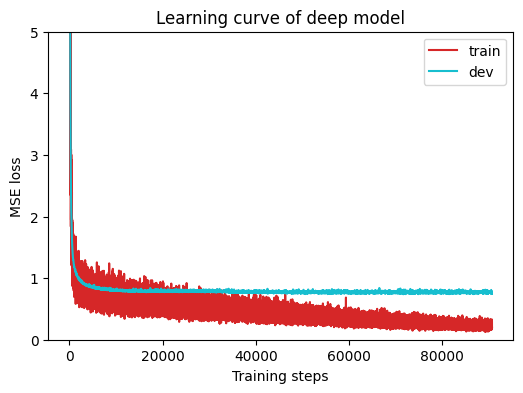

In [17]:
plot_learning_curve(model_loss_record, title='deep model')

In [ ]:
plot_learning_curve(model_loss_record_improve, title='deep model')

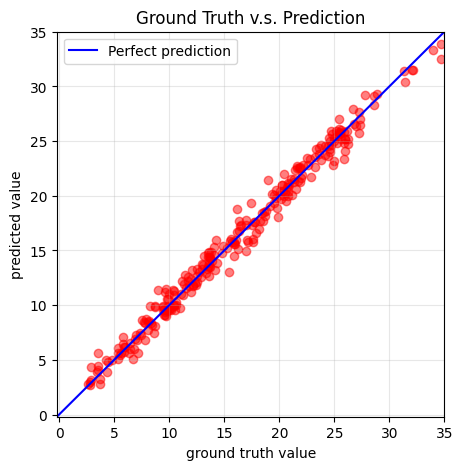

In [18]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'],weights_only= True, map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [19]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
